TUMOR DYNAMICS MODELING: THREE APPROACHES

This simulation implements three mathematical models of tumor dynamics:
1. PDE Model: Spatial reaction-diffusion equations
2. Agent-Based Model: Individual cell behavior and interactions
3. ODE Surrogate: Compartmentalized average dynamics

Running PDE Model Simulation...


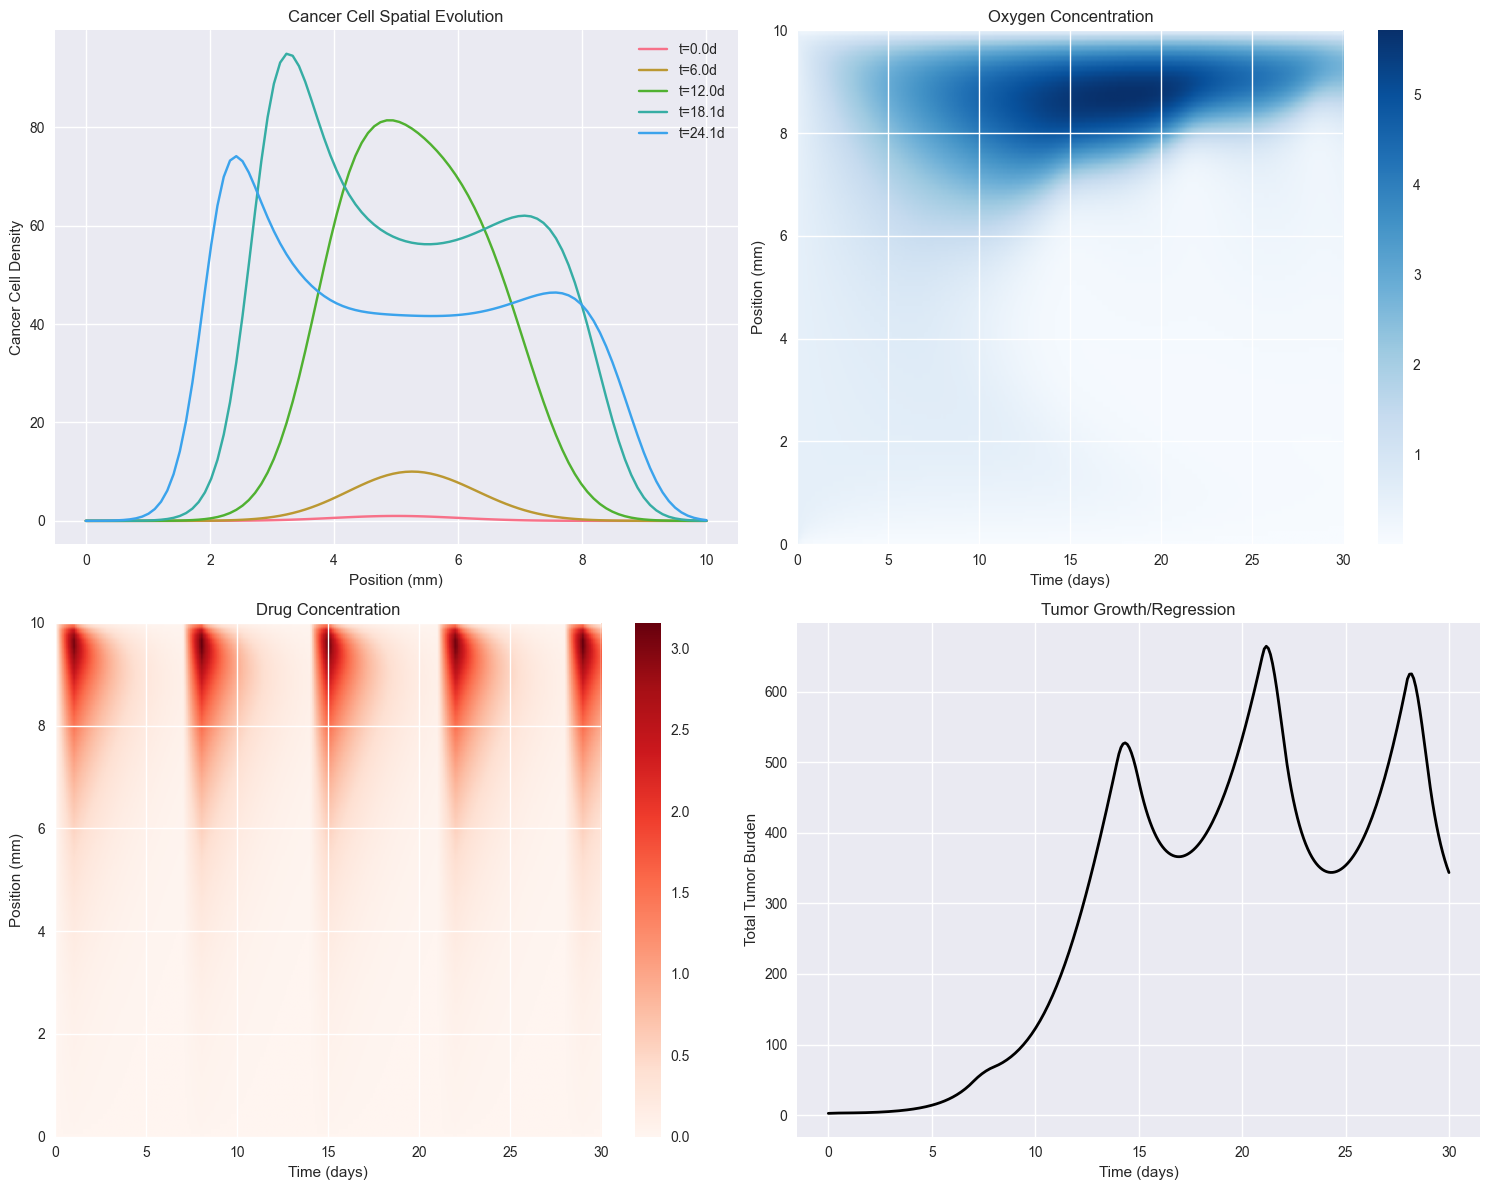


Running Agent-Based Model Simulation...


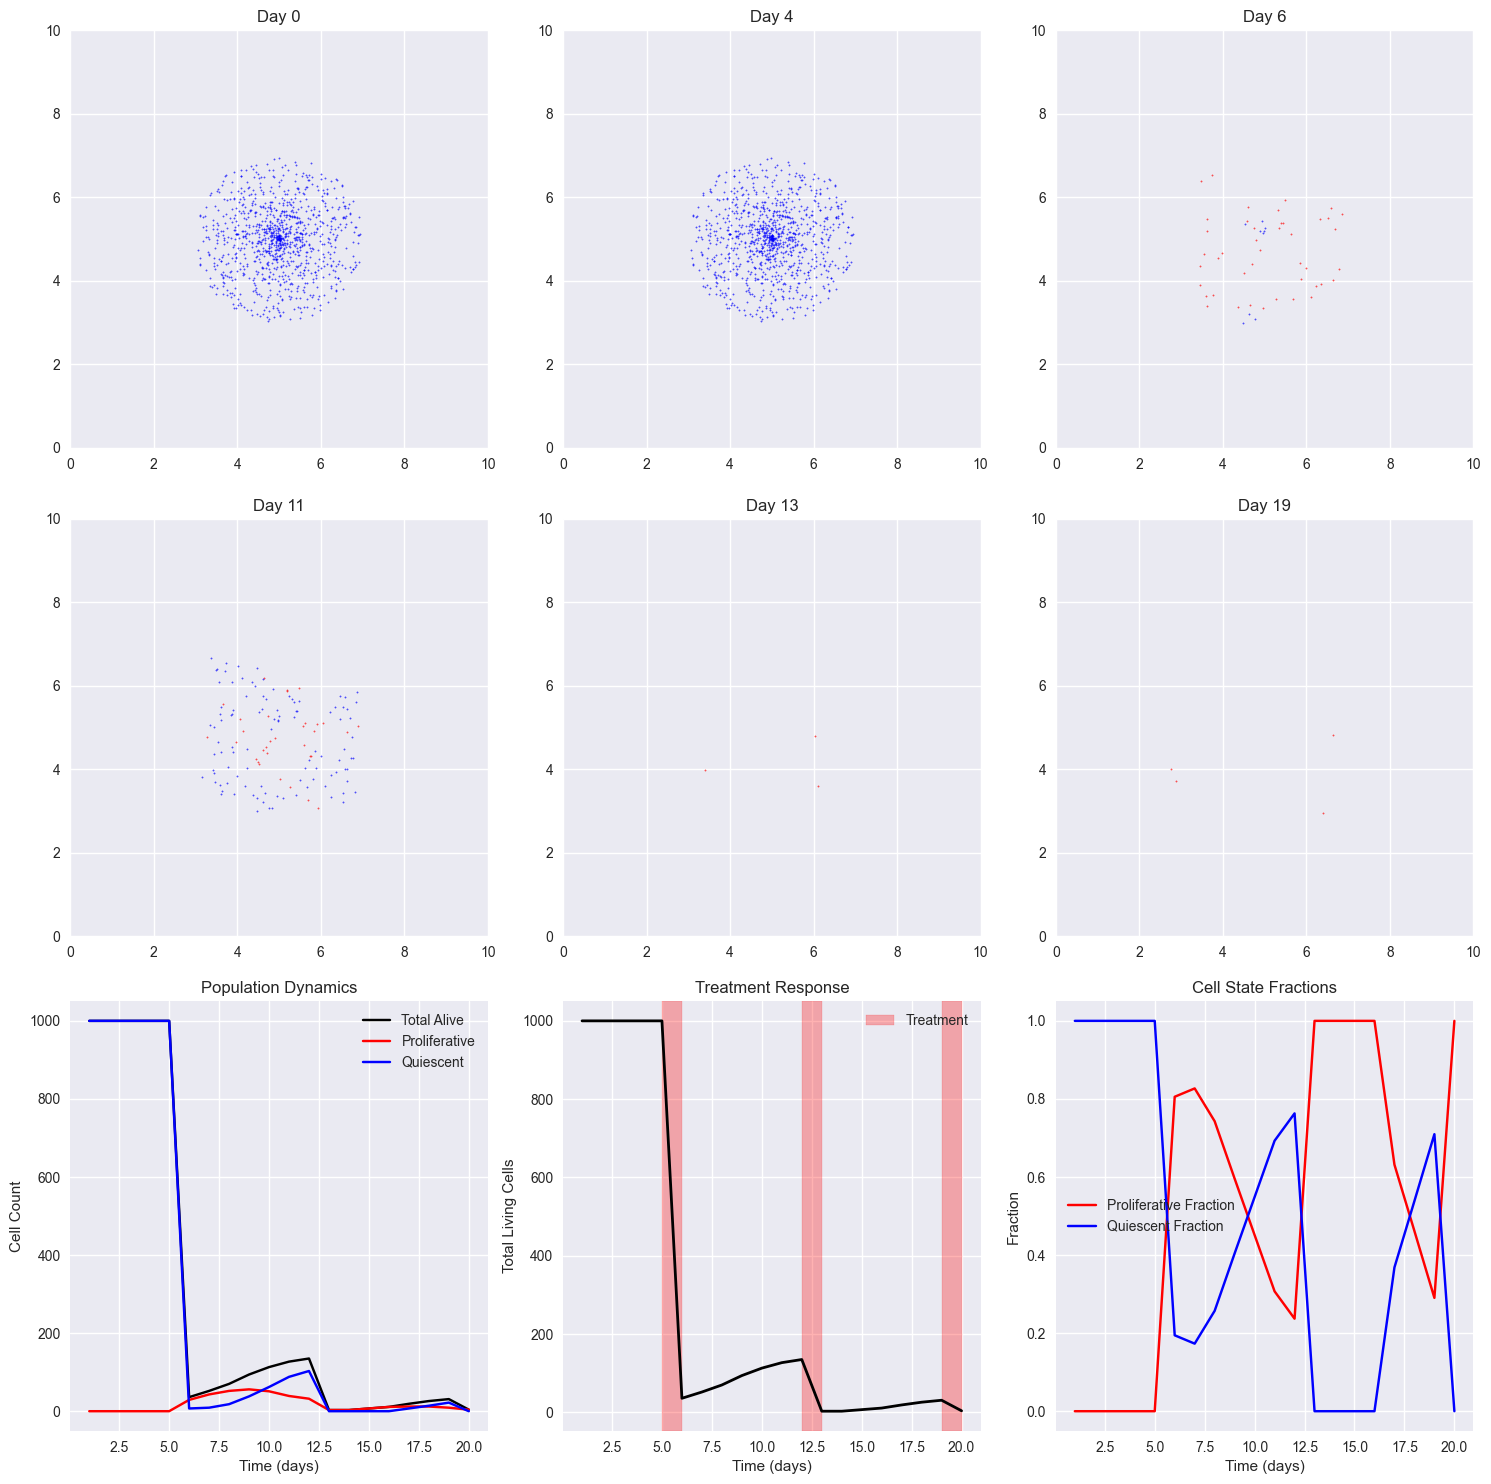


Running ODE Surrogate Model Simulation...


C:\Users\pauli\AppData\Local\Temp\ipykernel_24148\263429672.py:701: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
d:\anaconda3\envs\magisterka\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


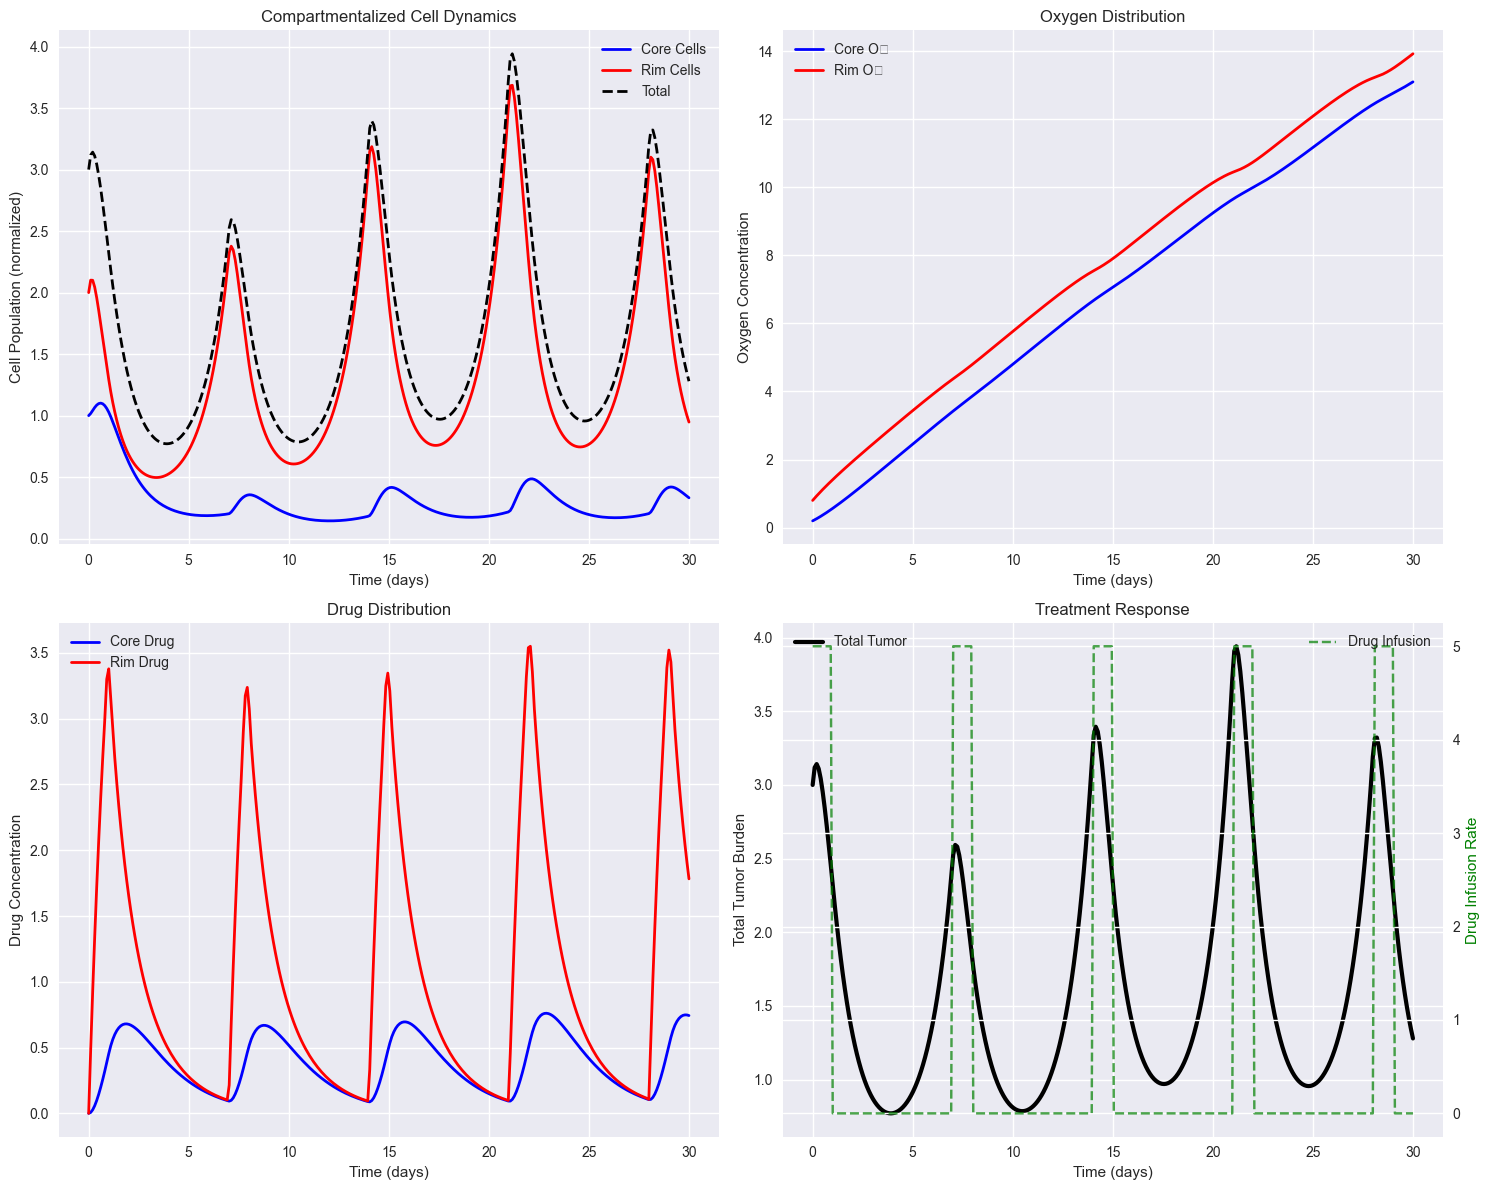


Comparing All Three Models...


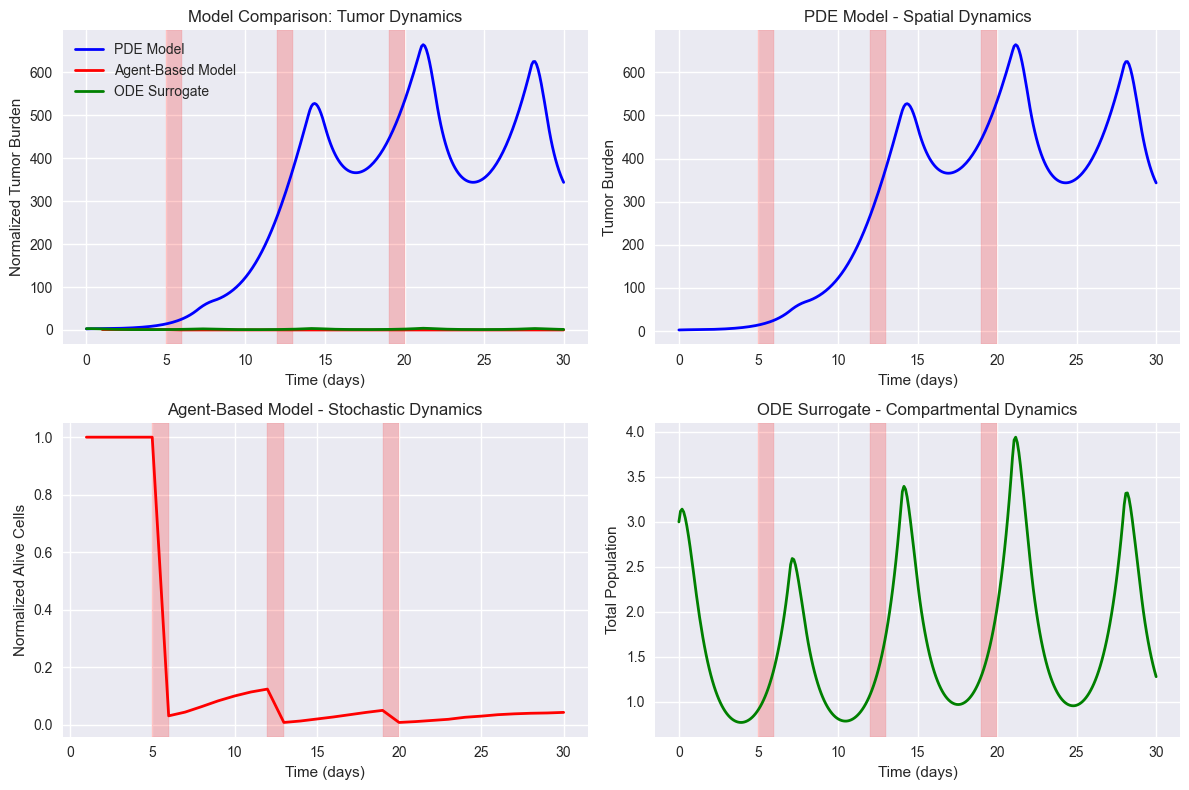


Simulation completed!

Model Summary:
----------------------------------------
PDE Model:
  • Captures spatial heterogeneity
  • Models diffusion of oxygen/drugs
  • Shows spatial patterns of response

Agent-Based Model:
  • Individual cell behaviors
  • Stochastic dynamics
  • Emergent population patterns

ODE Surrogate Model:
  • Computationally efficient
  • Captures key dynamics
  • Suitable for parameter exploration

EXTENDED ANALYSIS
Running Sensitivity Analysis...


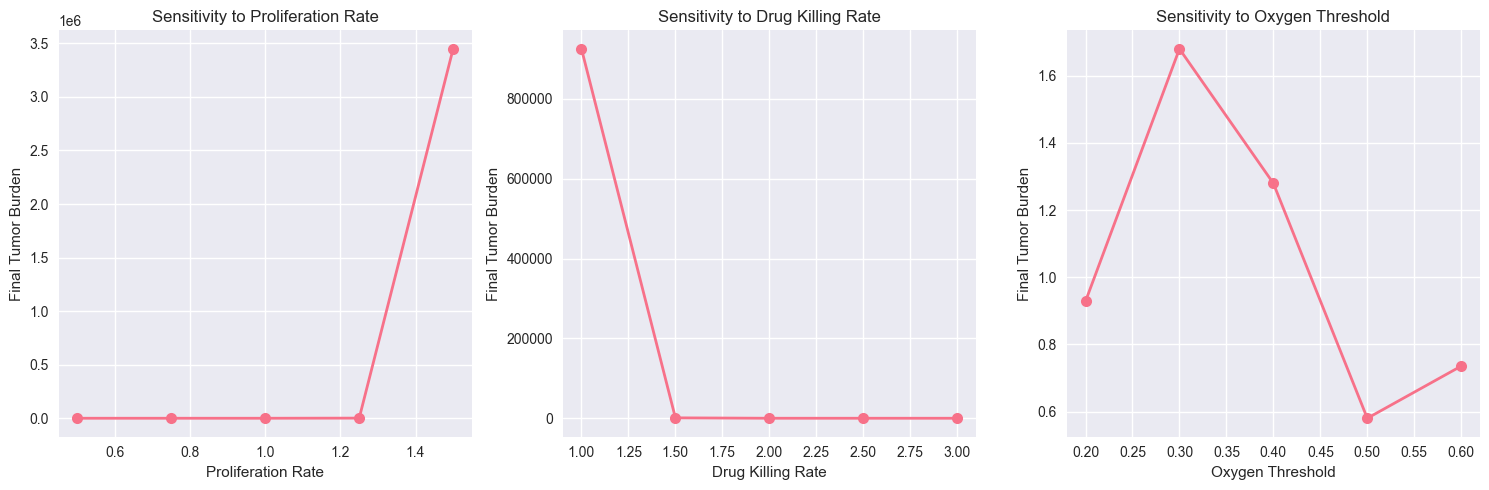


--------------------------------------------------
Phase Plane Analysis...


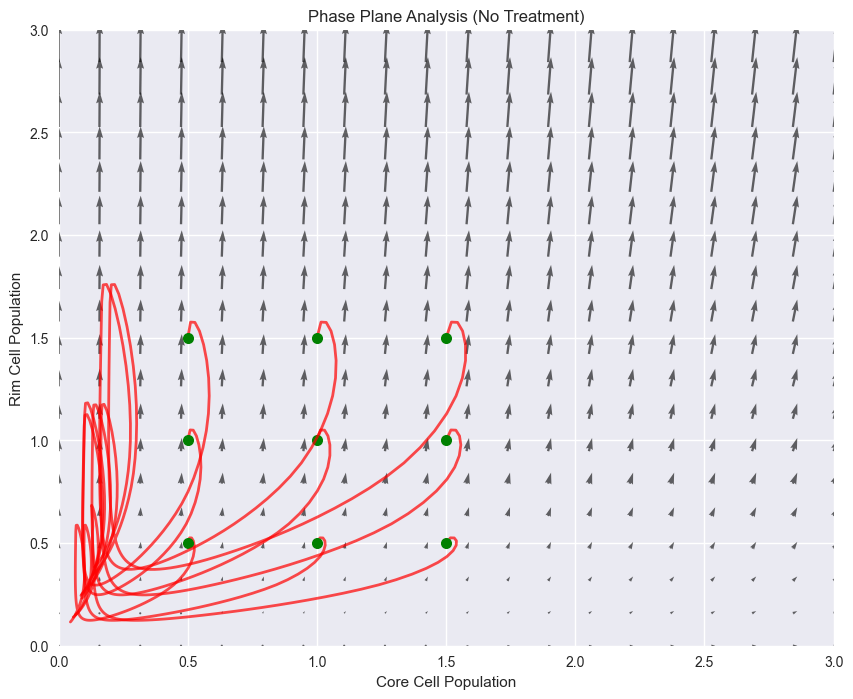


--------------------------------------------------
Treatment Schedule Optimization...


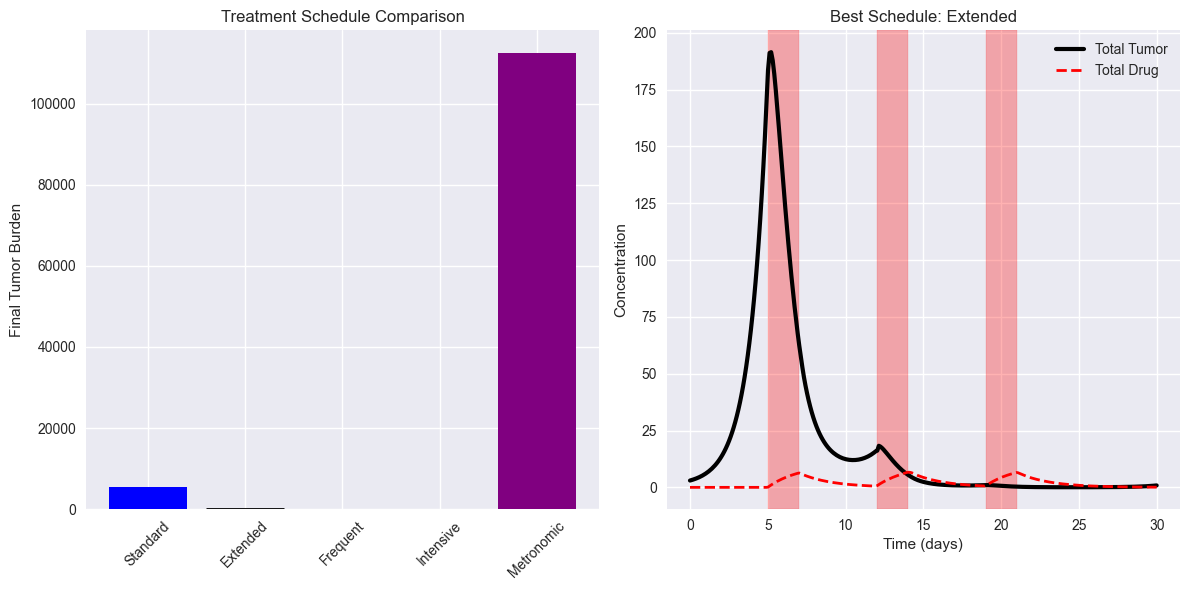

Best treatment schedule: Extended
Final tumor burden: 0.846


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
import random
from dataclasses import dataclass
from typing import List, Tuple
import seaborn as sns

# Set style for better plots
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")

# ==============================================================================
# 1. PARTIAL DIFFERENTIAL EQUATION (PDE) MODEL
# ==============================================================================


class TumorPDEModel:
    """
    Spatial tumor model using PDEs with reaction-diffusion dynamics.

    Equations:
    ∂C/∂t = D_c ∇²C - λ_c C + ρ(O) C - δ(D) C
    ∂O/∂t = D_o ∇²O + σ - γ C O
    ∂D/∂t = D_d ∇²D + I(t) σ  - η D

    Where:
    C(x,t) = Cancer cell density
    O(x,t) = Oxygen concentration
    D(x,t) = Drug concentration

    Parameters:
    D_c, D_o, D_d = Diffusion coefficients
    λ_c = Natural death rate
    ρ(O) = Oxygen-dependent proliferation rate
    δ(D) = Drug-induced death rate
    σ = Oxygen supply rate (near vasculature)
    γ = Oxygen consumption rate
    η = Drug decay rate
    I(t) = Drug infusion schedule
    """

    def __init__(self, nx=100, L=10.0):
        self.nx = nx  # Grid points
        self.L = L  # Domain size (mm)
        self.dx = L / (nx - 1)
        self.x = np.linspace(0, L, nx)

        # Model parameters
        self.params = {
            "D_c": 0.01,  # Cancer cell diffusion (mm²/day)
            "D_o": 0.1,  # Oxygen diffusion (mm²/day)
            "D_d": 0.05,  # Drug diffusion (mm²/day)
            "lambda_c": 0.1,  # Natural death rate (1/day)
            "rho_max": 1.2,  # Maximum proliferation rate (1/day)
            "K_o": 0.5,  # Oxygen half-saturation (mg/L)
            "delta_max": 2.0,  # Maximum drug killing rate (1/day)
            "K_d": 1.0,  # Drug half-saturation (mg/L)
            "sigma": 1.0,  # Oxygen supply rate (mg/L/day)
            "gamma": 0.01,  # Oxygen consumption rate (L/mg/day)
            "eta": 0.5,  # Drug decay rate (1/day)
            "r_vasc": 2.0,  # Vascular radius (mm)
        }

    def proliferation_rate(self, O):
        """Oxygen-dependent proliferation: ρ(O) = ρ_max * O/(K_o + O)"""
        return self.params["rho_max"] * O / (self.params["K_o"] + O)

    def death_rate(self, D):
        """Drug-induced death: δ(D) = δ_max * D/(K_d + D)"""
        return self.params["delta_max"] * D / (self.params["K_d"] + D)

    def oxygen_supply(self, x):
        """Oxygen supply near vasculature (exponential decay from boundary)"""
        return self.params["sigma"] * np.exp(-x / self.params["r_vasc"])

    def drug_infusion(self, t):
        """Drug infusion schedule - periodic treatment"""
        cycle_length = 7.0  # 7-day cycles
        treatment_duration = 1.0  # 1-day infusion
        cycle_time = t % cycle_length
        return 5.0 if cycle_time < treatment_duration else 0.0

    def laplacian_1d(self, u):
        """Compute 1D Laplacian using finite differences"""
        u_padded = np.pad(u, 1, mode="constant", constant_values=0)
        return (u_padded[2:] - 2 * u_padded[1:-1] + u_padded[:-2]) / self.dx**2

    def solve(self, t_span=(0, 30), n_points=300):
        """Solve the PDE system"""
        t_eval = np.linspace(t_span[0], t_span[1], n_points)

        # Initial conditions
        C0 = np.exp(-((self.x - 5) ** 2) / 2)  # Gaussian tumor
        O0 = np.ones_like(self.x) * 0.5  # Initial oxygen
        D0 = np.zeros_like(self.x)  # No initial drug
        y0 = np.concatenate([C0, O0, D0])

        def system(t, y):
            n = self.nx
            C, O, D = y[:n], y[n : 2 * n], y[2 * n :]

            # Compute spatial derivatives
            lap_C = self.laplacian_1d(C)
            lap_O = self.laplacian_1d(O)
            lap_D = self.laplacian_1d(D)

            # Compute reaction terms
            dC_dt = (
                self.params["D_c"] * lap_C
                - self.params["lambda_c"] * C
                + self.proliferation_rate(O) * C
                - self.death_rate(D) * C
            )

            dO_dt = (
                self.params["D_o"] * lap_O
                + self.oxygen_supply(self.x)
                - self.params["gamma"] * C * O
            )

            dD_dt = (
                self.params["D_d"] * lap_D
                + self.drug_infusion(t) * self.oxygen_supply(self.x)
                - self.params["eta"] * D
            )

            return np.concatenate([dC_dt, dO_dt, dD_dt])

        sol = solve_ivp(system, t_span, y0, t_eval=t_eval, method="RK45")
        return sol


# ==============================================================================
# 2. AGENT-BASED MODEL (ABM)
# ==============================================================================


@dataclass
class Cell:
    """Individual cancer cell with spatial position and state"""

    x: float
    y: float
    state: str  # 'proliferative', 'quiescent', 'dead'
    oxygen_level: float = 0.0
    drug_exposure: float = 0.0
    division_timer: float = 0.0


class TumorABM:
    """
    Agent-based model of tumor dynamics.

    Each cell is modeled as an individual agent with:
    - Spatial position (x, y)
    - State (proliferative, quiescent, dead)
    - Local oxygen and drug concentrations
    - Stochastic behavior based on local conditions

    Rules:
    1. Cells proliferate when oxygen > threshold and space available
    2. Cells become quiescent when oxygen < threshold
    3. Cells die when drug concentration > threshold
    4. Oxygen diffuses from boundaries with consumption
    5. Drug diffuses from vasculature with decay
    """

    def __init__(self, domain_size=10.0, initial_cells=1000):
        self.domain_size = domain_size
        self.cells: List[Cell] = []
        self.time = 0.0
        self.dt = 0.1

        # Model parameters
        self.params = {
            "oxygen_threshold": 0.4,  # Quiescence threshold
            "drug_threshold": 0.3,  # Death threshold
            "proliferation_rate": 1.5,  # Per day
            "death_rate": 3.0,  # Per day (with drug)
            "diffusion_rate": 0.1,  # Diffusion coefficient
            "oxygen_supply": 1.2,  # At boundaries
            "drug_supply": 0.0,  # Drug infusion
            "consumption_rate": 0.01,  # Oxygen consumption
            "max_neighbors": 6,  # Spatial constraint
            "division_time": 0.8,  # Days
        }

        # Initialize cells in a circular tumor
        self.initialize_tumor(initial_cells)

    def initialize_tumor(self, n_cells):
        """Initialize cells in a circular tumor configuration"""
        center = self.domain_size / 2
        for _ in range(n_cells):
            # Random position within tumor radius
            angle = random.uniform(0, 2 * np.pi)
            radius = random.uniform(0, 2.0)  # Initial tumor radius
            x = center + radius * np.cos(angle)
            y = center + radius * np.sin(angle)

            # Determine initial state based on distance from center
            dist_from_center = np.sqrt((x - center) ** 2 + (y - center) ** 2)
            state = "proliferative" if dist_from_center < 1.5 else "quiescent"

            self.cells.append(Cell(x, y, state))

    def get_local_concentrations(self, cell: Cell):
        """Calculate local oxygen and drug concentrations"""
        # Distance from tumor center (more realistic for avascular tumor)
        center = self.domain_size / 2
        dist_from_center = np.sqrt((cell.x - center) ** 2 + (cell.y - center) ** 2)

        # Oxygen decreases with distance from vasculature (at boundaries)
        dist_to_edge = min(
            cell.x, cell.y, self.domain_size - cell.x, self.domain_size - cell.y
        )

        # Oxygen is high near edges (vasculature) and low in center
        oxygen = self.params["oxygen_supply"] * np.exp(-dist_from_center / 2.0) + 0.1

        # Drug concentration (higher near vasculature, penetrates inward)
        drug = (
            self.params["drug_supply"] * np.exp(-dist_from_center / 1.5)
            if self.params["drug_supply"] > 0
            else 0.0
        )

        # Account for local cell density (competition for oxygen)
        local_density = self.get_local_density(cell)
        oxygen *= max(0.1, 1.0 - local_density / 15.0)

        return oxygen, drug

    def get_local_density(self, cell: Cell):
        """Count nearby cells within interaction radius"""
        count = 0
        for other in self.cells:
            if other != cell and other.state != "dead":
                dist = np.sqrt((cell.x - other.x) ** 2 + (cell.y - other.y) ** 2)
                if dist < 0.5:  # Interaction radius
                    count += 1
        return count

    def update_cell(self, cell: Cell):
        """Update individual cell state and behavior"""
        if cell.state == "dead":
            return

        # Get local environment
        oxygen, drug = self.get_local_concentrations(cell)
        cell.oxygen_level = oxygen
        cell.drug_exposure = drug

        # Drug-induced death
        if drug > self.params["drug_threshold"]:
            if random.random() < self.params["death_rate"] * self.dt:
                cell.state = "dead"
                return

        # State transitions based on oxygen
        if oxygen < self.params["oxygen_threshold"]:
            cell.state = "quiescent"
        else:
            if cell.state == "quiescent":
                cell.state = "proliferative"
                cell.division_timer = 0.0

        # Cell division
        if cell.state == "proliferative":
            cell.division_timer += self.dt
            local_density = self.get_local_density(cell)

            if (
                cell.division_timer >= self.params["division_time"]
                and local_density < self.params["max_neighbors"]
                and random.random() < self.params["proliferation_rate"] * self.dt
            ):
                # Create daughter cell nearby
                angle = random.uniform(0, 2 * np.pi)
                distance = 0.3
                new_x = cell.x + distance * np.cos(angle)
                new_y = cell.y + distance * np.sin(angle)

                # Keep within domain
                new_x = max(0, min(self.domain_size, new_x))
                new_y = max(0, min(self.domain_size, new_y))

                new_cell = Cell(new_x, new_y, "proliferative")
                self.cells.append(new_cell)
                cell.division_timer = 0.0

    def step(self):
        """Perform one simulation step"""
        # Create a copy of cells list to iterate over (avoid modification during iteration)
        cells_to_update = [cell for cell in self.cells if cell.state != "dead"]

        # Update all living cells
        for cell in cells_to_update:
            self.update_cell(cell)

        # Remove dead cells periodically to save memory
        if len(self.cells) > 2000:  # Clean up if too many dead cells
            self.cells = [
                cell
                for cell in self.cells
                if cell.state != "dead" or random.random() < 0.1
            ]

        self.time += self.dt

    def set_drug_treatment(self, active: bool):
        """Turn drug treatment on/off"""
        self.params["drug_supply"] = 1.5 if active else 0.0

    def get_statistics(self):
        """Get current tumor statistics"""
        states = {"proliferative": 0, "quiescent": 0, "dead": 0}
        for cell in self.cells:
            states[cell.state] += 1

        alive_cells = states["proliferative"] + states["quiescent"]
        return {
            "total_cells": len(self.cells),
            "alive_cells": alive_cells,
            "proliferative": states["proliferative"],
            "quiescent": states["quiescent"],
            "dead": states["dead"],
            "time": self.time,
        }


# ==============================================================================
# 3. ORDINARY DIFFERENTIAL EQUATION (ODE) SURROGATE MODEL
# ==============================================================================


class TumorODEModel:
    """
    Surrogate ODE model derived from spatial PDE through compartmentalization.

    Mathematical Derivation:
    The spatial domain is divided into concentric shells:
    - Core (r < R_core): Hypoxic region
    - Rim (R_core ≤ r < R_tumor): Well-oxygenated region

    Volume-averaged equations:
    dC_core/dt = -λ_c C_core + ρ_low C_core - δ(D_core) C_core + flux_in
    dC_rim/dt = -λ_c C_rim + ρ_high C_rim - δ(D_rim) C_rim - flux_in
    dO_core/dt = -γ C_core O_core + diffusion_flux_O
    dO_rim/dt = σ - γ C_rim O_rim - diffusion_flux_O
    dD_core/dt = -η D_core + diffusion_flux_D
    dD_rim/dt = I(t) - η D_rim - diffusion_flux_D

    Where flux terms represent transport between compartments.
    """

    def __init__(self):
        # Compartment parameters
        self.params = {
            # Core compartment
            "lambda_c": 0.1,  # Natural death rate (1/day)
            "rho_core": 0.2,  # Low proliferation in core (1/day)
            "rho_rim": 1.0,  # High proliferation in rim (1/day)
            "delta_max": 2.0,  # Maximum drug killing (1/day)
            "K_d": 1.0,  # Drug half-saturation
            # Oxygen dynamics
            "gamma": 0.01,  # Consumption rate
            "sigma": 1.0,  # Supply rate to rim
            "D_o_eff": 0.5,  # Effective oxygen diffusion
            # Drug dynamics
            "eta": 0.5,  # Decay rate (1/day)
            "D_d_eff": 0.3,  # Effective drug diffusion
            # Transport between compartments
            "k_transport": 0.1,  # Cell migration rate
            "A_interface": 1.0,  # Interface area scaling
        }

    def drug_infusion(self, t):
        """Drug infusion schedule"""
        cycle_length = 7.0
        treatment_duration = 1.0
        cycle_time = t % cycle_length
        return 5.0 if cycle_time < treatment_duration else 0.0

    def death_rate(self, D):
        """Drug-induced death rate"""
        return self.params["delta_max"] * D / (self.params["K_d"] + D)

    def system_equations(self, t, y):
        """
        ODE system for compartmentalized tumor model

        State variables:
        y[0] = C_core  (cancer cells in core)
        y[1] = C_rim   (cancer cells in rim)
        y[2] = O_core  (oxygen in core)
        y[3] = O_rim   (oxygen in rim)
        y[4] = D_core  (drug in core)
        y[5] = D_rim   (drug in rim)
        """
        C_core, C_rim, O_core, O_rim, D_core, D_rim = y

        # Drug-induced death rates
        death_core = self.death_rate(D_core)
        death_rim = self.death_rate(D_rim)

        # Cell transport (rim → core when rim cells die)
        cell_flux = self.params["k_transport"] * (death_rim * C_rim)

        # Oxygen transport (rim → core)
        oxygen_flux = (
            self.params["D_o_eff"] * self.params["A_interface"] * (O_rim - O_core)
        )

        # Drug transport (rim → core)
        drug_flux = (
            self.params["D_d_eff"] * self.params["A_interface"] * (D_rim - D_core)
        )

        # Core dynamics
        dC_core_dt = (
            -self.params["lambda_c"] * C_core
            + self.params["rho_core"] * C_core
            - death_core * C_core
            + cell_flux
        )

        # Rim dynamics
        dC_rim_dt = (
            -self.params["lambda_c"] * C_rim
            + self.params["rho_rim"] * C_rim
            - death_rim * C_rim
            - cell_flux
        )

        # Oxygen dynamics
        dO_core_dt = -self.params["gamma"] * C_core * O_core + oxygen_flux

        dO_rim_dt = (
            self.params["sigma"] - self.params["gamma"] * C_rim * O_rim - oxygen_flux
        )

        # Drug dynamics
        dD_core_dt = -self.params["eta"] * D_core + drug_flux

        dD_rim_dt = self.drug_infusion(t) - self.params["eta"] * D_rim - drug_flux

        return [dC_core_dt, dC_rim_dt, dO_core_dt, dO_rim_dt, dD_core_dt, dD_rim_dt]

    def solve(self, t_span=(0, 30), n_points=300):
        """Solve the ODE system"""
        t_eval = np.linspace(t_span[0], t_span[1], n_points)

        # Initial conditions
        y0 = [
            1.0,  # C_core (normalized)
            2.0,  # C_rim (normalized)
            0.2,  # O_core (low oxygen)
            0.8,  # O_rim (high oxygen)
            0.0,  # D_core (no initial drug)
            0.0,  # D_rim (no initial drug)
        ]

        sol = solve_ivp(self.system_equations, t_span, y0, t_eval=t_eval, method="RK45")
        return sol


# ==============================================================================
# SIMULATION AND VISUALIZATION
# ==============================================================================


def run_pde_simulation():
    """Run and visualize PDE model"""
    print("Running PDE Model Simulation...")
    model = TumorPDEModel()
    sol = model.solve()

    # Extract solutions
    n = model.nx
    t = sol.t
    C = sol.y[:n, :]
    O = sol.y[n : 2 * n, :]
    D = sol.y[2 * n :, :]

    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Plot 1: Cancer cell evolution
    ax = axes[0, 0]
    for i in range(0, len(t), len(t) // 5):
        ax.plot(model.x, C[:, i], label=f"t={t[i]:.1f}d")
    ax.set_xlabel("Position (mm)")
    ax.set_ylabel("Cancer Cell Density")
    ax.set_title("Cancer Cell Spatial Evolution")
    ax.legend()
    ax.grid(True)

    # Plot 2: Oxygen distribution
    ax = axes[0, 1]
    im = ax.imshow(O, extent=[0, t[-1], 0, model.L], aspect="auto", cmap="Blues")
    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Position (mm)")
    ax.set_title("Oxygen Concentration")
    plt.colorbar(im, ax=ax)

    # Plot 3: Drug distribution
    ax = axes[1, 0]
    im = ax.imshow(D, extent=[0, t[-1], 0, model.L], aspect="auto", cmap="Reds")
    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Position (mm)")
    ax.set_title("Drug Concentration")
    plt.colorbar(im, ax=ax)

    # Plot 4: Total tumor burden
    ax = axes[1, 1]
    total_cells = np.trapz(C, axis=0, dx=model.dx)
    ax.plot(t, total_cells, "k-", linewidth=2)
    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Total Tumor Burden")
    ax.set_title("Tumor Growth/Regression")
    ax.grid(True)

    plt.tight_layout()
    plt.show()


def run_abm_simulation():
    """Run and visualize Agent-Based Model"""
    print("Running Agent-Based Model Simulation...")
    model = TumorABM()

    # Simulation parameters
    days = 20
    steps_per_day = 10
    treatment_start = 5
    treatment_cycles = [(5, 6), (12, 13), (19, 20)]  # Treatment periods

    # Storage for results
    statistics = []
    snapshots = []

    for day in range(days):
        # Check if treatment should be active
        treatment_active = any(start <= day < end for start, end in treatment_cycles)
        model.set_drug_treatment(treatment_active)

        # Run simulation for one day
        for _ in range(steps_per_day):
            model.step()

        # Store statistics
        stats = model.get_statistics()
        statistics.append(stats)

        # Store snapshots at key timepoints
        if day in [0, 4, 6, 11, 13, 19]:
            snapshot = {
                "day": day,
                "cells": [
                    (c.x, c.y, c.state) for c in model.cells if c.state != "dead"
                ],
            }
            snapshots.append(snapshot)

    # Visualization
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))

    # Plot spatial snapshots (first 6 subplots)
    colors = {"proliferative": "red", "quiescent": "blue", "dead": "gray"}
    for i, snapshot in enumerate(snapshots):
        row = i // 3
        col = i % 3
        ax = axes[row, col]

        for x, y, state in snapshot["cells"]:
            ax.scatter(x, y, c=colors[state], s=1, alpha=0.6)

        ax.set_xlim(0, model.domain_size)
        ax.set_ylim(0, model.domain_size)
        ax.set_title(f"Day {snapshot['day']}")
        ax.set_aspect("equal")

    # Plot population dynamics
    ax = axes[2, 0]
    times = [s["time"] for s in statistics]
    ax.plot(times, [s["alive_cells"] for s in statistics], "k-", label="Total Alive")
    ax.plot(
        times, [s["proliferative"] for s in statistics], "r-", label="Proliferative"
    )
    ax.plot(times, [s["quiescent"] for s in statistics], "b-", label="Quiescent")
    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Cell Count")
    ax.set_title("Population Dynamics")
    ax.legend()
    ax.grid(True)

    # Plot treatment response
    ax = axes[2, 1]
    ax.plot(times, [s["alive_cells"] for s in statistics], "k-", linewidth=2)
    for start, end in treatment_cycles:
        ax.axvspan(
            start,
            end,
            alpha=0.3,
            color="red",
            label="Treatment" if start == treatment_cycles[0][0] else "",
        )
    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Total Living Cells")
    ax.set_title("Treatment Response")
    ax.legend()
    ax.grid(True)

    # Plot state fractions
    ax = axes[2, 2]
    prolif_frac = [s["proliferative"] / max(s["alive_cells"], 1) for s in statistics]
    quiesc_frac = [s["quiescent"] / max(s["alive_cells"], 1) for s in statistics]
    ax.plot(times, prolif_frac, "r-", label="Proliferative Fraction")
    ax.plot(times, quiesc_frac, "b-", label="Quiescent Fraction")
    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Fraction")
    ax.set_title("Cell State Fractions")
    ax.legend()
    ax.grid(True)

    plt.tight_layout()
    plt.show()


def run_ode_simulation():
    """Run and visualize ODE surrogate model"""
    print("Running ODE Surrogate Model Simulation...")
    model = TumorODEModel()
    sol = model.solve()

    # Extract solutions
    t = sol.t
    C_core = sol.y[0, :]
    C_rim = sol.y[1, :]
    O_core = sol.y[2, :]
    O_rim = sol.y[3, :]
    D_core = sol.y[4, :]
    D_rim = sol.y[5, :]

    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Plot 1: Cell populations
    ax = axes[0, 0]
    ax.plot(t, C_core, "b-", label="Core Cells", linewidth=2)
    ax.plot(t, C_rim, "r-", label="Rim Cells", linewidth=2)
    ax.plot(t, C_core + C_rim, "k--", label="Total", linewidth=2)
    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Cell Population (normalized)")
    ax.set_title("Compartmentalized Cell Dynamics")
    ax.legend()
    ax.grid(True)

    # Plot 2: Oxygen levels
    ax = axes[0, 1]
    ax.plot(t, O_core, "b-", label="Core O₂", linewidth=2)
    ax.plot(t, O_rim, "r-", label="Rim O₂", linewidth=2)
    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Oxygen Concentration")
    ax.set_title("Oxygen Distribution")
    ax.legend()
    ax.grid(True)

    # Plot 3: Drug concentrations
    ax = axes[1, 0]
    ax.plot(t, D_core, "b-", label="Core Drug", linewidth=2)
    ax.plot(t, D_rim, "r-", label="Rim Drug", linewidth=2)
    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Drug Concentration")
    ax.set_title("Drug Distribution")
    ax.legend()
    ax.grid(True)

    # Plot 4: Treatment schedule and response
    ax = axes[1, 1]
    # Drug infusion schedule
    drug_schedule = [model.drug_infusion(ti) for ti in t]
    ax2 = ax.twinx()
    ax2.plot(t, drug_schedule, "g--", alpha=0.7, label="Drug Infusion")
    ax2.set_ylabel("Drug Infusion Rate", color="g")

    # Total tumor burden
    total_tumor = C_core + C_rim
    ax.plot(t, total_tumor, "k-", linewidth=3, label="Total Tumor")
    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Total Tumor Burden")
    ax.set_title("Treatment Response")
    ax.legend(loc="upper left")
    ax2.legend(loc="upper right")
    ax.grid(True)

    plt.tight_layout()
    plt.show()


def compare_models():
    """Compare all three models"""
    print("Comparing All Three Models...")

    # Run all models
    pde_model = TumorPDEModel()
    pde_sol = pde_model.solve()

    abm_model = TumorABM()
    abm_stats = []
    for day in range(30):
        if 5 <= day < 6 or 12 <= day < 13 or 19 <= day < 20:
            abm_model.set_drug_treatment(True)
        else:
            abm_model.set_drug_treatment(False)
        for _ in range(10):
            abm_model.step()
        abm_stats.append(abm_model.get_statistics())

    ode_model = TumorODEModel()
    ode_sol = ode_model.solve()

    # Extract tumor burdens
    pde_t = pde_sol.t
    pde_burden = np.trapz(pde_sol.y[: pde_model.nx, :], axis=0, dx=pde_model.dx)

    abm_t = [s["time"] for s in abm_stats]
    abm_burden = [s["alive_cells"] / 1000 for s in abm_stats]  # Normalize

    ode_t = ode_sol.t
    ode_burden = ode_sol.y[0, :] + ode_sol.y[1, :]  # Core + Rim

    # Create comparison plot
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.plot(pde_t, pde_burden, "b-", label="PDE Model", linewidth=2)
    plt.plot(abm_t, abm_burden, "r-", label="Agent-Based Model", linewidth=2)
    plt.plot(ode_t, ode_burden, "g-", label="ODE Surrogate", linewidth=2)
    plt.xlabel("Time (days)")
    plt.ylabel("Normalized Tumor Burden")
    plt.title("Model Comparison: Tumor Dynamics")
    plt.legend()
    plt.grid(True)

    # Treatment periods
    treatment_periods = [(5, 6), (12, 13), (19, 20)]
    for start, end in treatment_periods:
        plt.axvspan(start, end, alpha=0.2, color="red")

    # Individual model details
    plt.subplot(2, 2, 2)
    plt.plot(pde_t, pde_burden, "b-", linewidth=2)
    plt.title("PDE Model - Spatial Dynamics")
    plt.xlabel("Time (days)")
    plt.ylabel("Tumor Burden")
    plt.grid(True)
    for start, end in treatment_periods:
        plt.axvspan(start, end, alpha=0.2, color="red")

    plt.subplot(2, 2, 3)
    plt.plot(abm_t, abm_burden, "r-", linewidth=2)
    plt.title("Agent-Based Model - Stochastic Dynamics")
    plt.xlabel("Time (days)")
    plt.ylabel("Normalized Alive Cells")
    plt.grid(True)
    for start, end in treatment_periods:
        plt.axvspan(start, end, alpha=0.2, color="red")

    plt.subplot(2, 2, 4)
    plt.plot(ode_t, ode_burden, "g-", linewidth=2)
    plt.title("ODE Surrogate - Compartmental Dynamics")
    plt.xlabel("Time (days)")
    plt.ylabel("Total Population")
    plt.grid(True)
    for start, end in treatment_periods:
        plt.axvspan(start, end, alpha=0.2, color="red")

    plt.tight_layout()
    plt.show()


# ==============================================================================
# MAIN EXECUTION
# ==============================================================================

if __name__ == "__main__":
    print("=" * 80)
    print("TUMOR DYNAMICS MODELING: THREE APPROACHES")
    print("=" * 80)
    print()

    print("This simulation implements three mathematical models of tumor dynamics:")
    print("1. PDE Model: Spatial reaction-diffusion equations")
    print("2. Agent-Based Model: Individual cell behavior and interactions")
    print("3. ODE Surrogate: Compartmentalized average dynamics")
    print()

    # Run individual simulations
    try:
        run_pde_simulation()
        print("\n" + "=" * 50)

        run_abm_simulation()
        print("\n" + "=" * 50)

        run_ode_simulation()
        print("\n" + "=" * 50)

        compare_models()

    except Exception as e:
        print(f"Error during simulation: {e}")
        import traceback

        traceback.print_exc()

    print("\nSimulation completed!")
    print("\nModel Summary:")
    print("-" * 40)
    print("PDE Model:")
    print("  • Captures spatial heterogeneity")
    print("  • Models diffusion of oxygen/drugs")
    print("  • Shows spatial patterns of response")
    print()
    print("Agent-Based Model:")
    print("  • Individual cell behaviors")
    print("  • Stochastic dynamics")
    print("  • Emergent population patterns")
    print()
    print("ODE Surrogate Model:")
    print("  • Computationally efficient")
    print("  • Captures key dynamics")
    print("  • Suitable for parameter exploration")

# ==============================================================================
# ADDITIONAL ANALYSIS FUNCTIONS
# ==============================================================================


def sensitivity_analysis():
    """Perform sensitivity analysis on key parameters"""
    print("Running Sensitivity Analysis...")

    # Parameters to vary
    param_ranges = {
        "proliferation_rate": np.linspace(0.5, 1.5, 5),
        "drug_killing_rate": np.linspace(1.0, 3.0, 5),
        "oxygen_threshold": np.linspace(0.2, 0.6, 5),
    }

    results = {}

    for param_name, param_values in param_ranges.items():
        results[param_name] = []

        for param_value in param_values:
            # Create model with modified parameter
            model = TumorODEModel()

            if param_name == "proliferation_rate":
                model.params["rho_rim"] = param_value
            elif param_name == "drug_killing_rate":
                model.params["delta_max"] = param_value
            elif param_name == "oxygen_threshold":
                model.params["rho_core"] = param_value * 0.5

            # Solve and extract final tumor burden
            sol = model.solve()
            final_burden = sol.y[0, -1] + sol.y[1, -1]
            results[param_name].append(final_burden)

    # Plot sensitivity results
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for i, (param_name, param_values) in enumerate(param_ranges.items()):
        axes[i].plot(param_values, results[param_name], "o-", linewidth=2, markersize=8)
        axes[i].set_xlabel(param_name.replace("_", " ").title())
        axes[i].set_ylabel("Final Tumor Burden")
        axes[i].set_title(f"Sensitivity to {param_name.replace('_', ' ').title()}")
        axes[i].grid(True)

    plt.tight_layout()
    plt.show()


def phase_plane_analysis():
    """Analyze the phase plane of the ODE system"""
    print("Phase Plane Analysis...")

    model = TumorODEModel()

    # Create phase plane for core vs rim cells
    C_core_range = np.linspace(0, 3, 20)
    C_rim_range = np.linspace(0, 3, 20)

    C_core_grid, C_rim_grid = np.meshgrid(C_core_range, C_rim_range)

    # Calculate vector field (without drug treatment)
    dC_core_dt = np.zeros_like(C_core_grid)
    dC_rim_dt = np.zeros_like(C_rim_grid)

    for i in range(len(C_core_range)):
        for j in range(len(C_rim_range)):
            # Set state with fixed oxygen and no drug
            state = [C_core_grid[j, i], C_rim_grid[j, i], 0.3, 0.7, 0.0, 0.0]
            derivatives = model.system_equations(0, state)
            dC_core_dt[j, i] = derivatives[0]
            dC_rim_dt[j, i] = derivatives[1]

    # Plot phase plane
    plt.figure(figsize=(10, 8))
    plt.quiver(
        C_core_grid, C_rim_grid, dC_core_dt, dC_rim_dt, alpha=0.6, scale=50, width=0.003
    )

    # Add some trajectories
    for C_core_init in [0.5, 1.0, 1.5]:
        for C_rim_init in [0.5, 1.0, 1.5]:
            y0 = [C_core_init, C_rim_init, 0.3, 0.7, 0.0, 0.0]
            sol = solve_ivp(
                model.system_equations, (0, 10), y0, t_eval=np.linspace(0, 10, 100)
            )
            plt.plot(sol.y[0, :], sol.y[1, :], "r-", alpha=0.7, linewidth=2)
            plt.plot(sol.y[0, 0], sol.y[1, 0], "go", markersize=8)

    plt.xlabel("Core Cell Population")
    plt.ylabel("Rim Cell Population")
    plt.title("Phase Plane Analysis (No Treatment)")
    plt.grid(True)
    plt.xlim(0, 3)
    plt.ylim(0, 3)
    plt.show()


def treatment_optimization():
    """Optimize treatment scheduling"""
    print("Treatment Schedule Optimization...")

    def treatment_outcome(schedule):
        """Evaluate treatment outcome for given schedule"""
        model = TumorODEModel()

        # Modify drug infusion function
        def custom_drug_infusion(t):
            for start, duration in schedule:
                if start <= t < start + duration:
                    return 5.0
            return 0.0

        model.drug_infusion = custom_drug_infusion
        sol = model.solve(t_span=(0, 30))

        # Return final tumor burden (to minimize)
        return sol.y[0, -1] + sol.y[1, -1]

    # Test different schedules
    schedules = [
        [(5, 1), (12, 1), (19, 1)],  # Standard: 3 doses, 1 day each
        [(5, 2), (12, 2), (19, 2)],  # Longer doses
        [(5, 1), (8, 1), (11, 1), (14, 1), (17, 1)],  # More frequent
        [(2, 3), (15, 3)],  # Bigger doses, less frequent
        [(5, 0.5), (7, 0.5), (9, 0.5), (11, 0.5), (13, 0.5)],  # Metronomic
    ]

    schedule_names = ["Standard", "Extended", "Frequent", "Intensive", "Metronomic"]

    outcomes = []
    for schedule in schedules:
        outcome = treatment_outcome(schedule)
        outcomes.append(outcome)

    # Plot optimization results
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    bars = plt.bar(
        schedule_names, outcomes, color=["blue", "green", "red", "orange", "purple"]
    )
    plt.ylabel("Final Tumor Burden")
    plt.title("Treatment Schedule Comparison")
    plt.xticks(rotation=45)

    # Highlight best schedule
    best_idx = np.argmin(outcomes)
    bars[best_idx].set_color("gold")
    bars[best_idx].set_edgecolor("black")
    bars[best_idx].set_linewidth(2)

    # Show detailed dynamics for best schedule
    plt.subplot(1, 2, 2)
    best_schedule = schedules[best_idx]

    def best_drug_infusion(t):
        for start, duration in best_schedule:
            if start <= t < start + duration:
                return 5.0
        return 0.0

    model = TumorODEModel()
    model.drug_infusion = best_drug_infusion
    sol = model.solve()

    plt.plot(sol.t, sol.y[0, :] + sol.y[1, :], "k-", linewidth=3, label="Total Tumor")
    plt.plot(sol.t, sol.y[4, :] + sol.y[5, :], "r--", linewidth=2, label="Total Drug")

    # Mark treatment periods
    for start, duration in best_schedule:
        plt.axvspan(start, start + duration, alpha=0.3, color="red")

    plt.xlabel("Time (days)")
    plt.ylabel("Concentration")
    plt.title(f"Best Schedule: {schedule_names[best_idx]}")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    print(f"Best treatment schedule: {schedule_names[best_idx]}")
    print(f"Final tumor burden: {outcomes[best_idx]:.3f}")


# Add these functions to the main execution
def run_extended_analysis():
    """Run extended analysis functions"""
    print("\n" + "=" * 80)
    print("EXTENDED ANALYSIS")
    print("=" * 80)

    sensitivity_analysis()
    print("\n" + "-" * 50)

    phase_plane_analysis()
    print("\n" + "-" * 50)

    treatment_optimization()


# Uncomment the line below to run extended analysis
run_extended_analysis()